In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)
# we use regex here to parse the output log files
import re

Populating the interactive namespace from numpy and matplotlib


In [3]:
# global variables
FOLDER_PREFIX="resnet_test_cpu_worker"

worker_num_interval = [2, 4, 8, 16, 32, 64]
single_node_time=5867.51

In [4]:
global_dict_saver = []
for num_w in worker_num_interval:
    # master is also include in this one, so the first worker should be the master
    time_stats_dict = {}
    for worker_index in range(num_w):
        if worker_index == 0:
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_master', 'rb')
        else:
            # for the case of 8 workers, we only consider master, worker0,...,worker6
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_worker_'+str(worker_index-1), 'rb')
        for line in out_file.readlines():
            line_string = line.rstrip('\n')
            search_sth = re.match('INFO:tensorflow:Worker(.*): (.*): step (.*), loss = (.*).* examples/sec; (.*) sec/batch.*', line_string)
            if search_sth:
                worker_index, cur_step, worker_time_cost = int(search_sth.group(1)), int(search_sth.group(3)), float(search_sth.group(5))
                if cur_step <= 300:
                    #print(worker_index, cur_step, worker_time_cost)
                    if cur_step not in time_stats_dict.keys():
                        time_stats_dict[cur_step]=[worker_time_cost]
                    else:
                        time_stats_dict[cur_step].append(worker_time_cost)
    global_dict_saver.append(time_stats_dict)

normal_speedup_vals = [1.0,]
ideal_speedup_vals = [1.0,]
for dict_idx, stat_dict in enumerate(global_dict_saver):
    ideal_counter_ = 0
    full_counter_ = 0
    for k, v in stat_dict.iteritems():
        ideal_counter_+=min(v)
        full_counter_+=max(v)
    normal_speedup_vals.append(float(single_node_time)/full_counter_)
    ideal_speedup_vals.append(float(single_node_time)/ideal_counter_)
    print("Cluster set up with {} workers: ideal time: {} full time:{}".format(worker_num_interval[dict_idx], ideal_counter_, full_counter_))

Cluster set up with 2 workers: ideal time: 2720.03 full time:2933.755
Cluster set up with 4 workers: ideal time: 1412.692 full time:1539.568
Cluster set up with 8 workers: ideal time: 753.347 full time:834.614
Cluster set up with 16 workers: ideal time: 440.178 full time:518.138
Cluster set up with 32 workers: ideal time: 246.876 full time:317.019
Cluster set up with 64 workers: ideal time: 273.967 full time:371.204


In [6]:
print(normal_speedup_vals)
print
print(ideal_speedup_vals)
workers_interval=[1, 2, 4, 8, 16, 32, 64]

[1.0, 2.000000000000001, 3.8111405277324555, 7.030207976381899, 11.324222504429319, 18.508385932704332, 15.80669928125776]

[1.0, 2.157149002033065, 4.153424808804748, 7.788588791088313, 13.32985746675207, 23.767032842398613, 21.41684947457175]


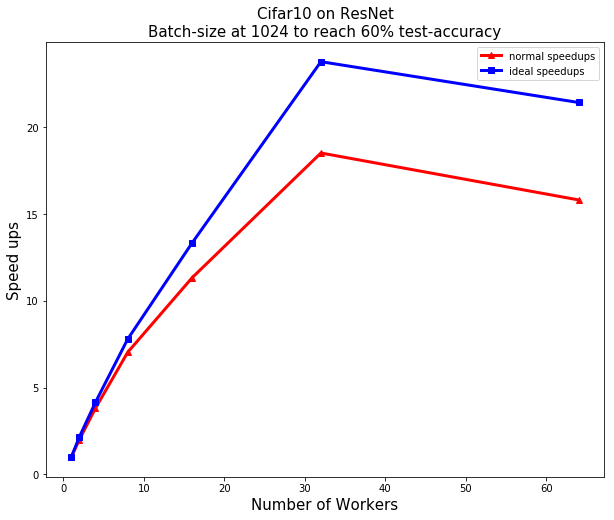

In [9]:
fig=plt.figure(1)
plt.plot(workers_interval, normal_speedup_vals, '-^r', linewidth=3.0, label="normal speedups")
plt.plot(workers_interval, ideal_speedup_vals, '-sb', linewidth=3.0, label='ideal speedups')
plt.title("Cifar10 on ResNet\nBatch-size at 1024 to reach 60% test-accuracy", multialignment='center',
         fontsize=15)
plt.xlabel("Number of Workers", fontsize=15)
plt.ylabel("Speed ups", fontsize=15)
plt.legend()
plt.show()